In [8]:
"""
01_preprocessing.py
Clean, professional preprocessing pipeline for the ByteBuzz project.
"""

'\n01_preprocessing.py\nClean, professional preprocessing pipeline for the ByteBuzz project.\n'

In [9]:
# Standard imports
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Data science
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Preprocessing & modeling helpers
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [14]:
# Paths (adjust if needed)
# Ensure directories exist
for d in (DATA_DIR, NOTEBOOK_DIR, MODELS_DIR):
    d.mkdir(parents=True, exist_ok=True)

RAW_CSV_PATH = Path("/mnt/data/processed_dataset.csv")  # uploaded dataset
PROCESSED_CSV_PATH = OUT_DIR / "processed_features.csv"
SCALER_PATH = MODELS_DIR / "scaler.joblib"
PREPROCESSOR_PATH = MODELS_DIR / "preprocessor.joblib"

def save_joblib(obj, path):
    path.parent.mkdir(parents=True, exist_ok=True)
    joblib.dump(obj, path)
    print(f"Saved: {path}")

def load_joblib(path):
    return joblib.load(path)


In [17]:
from pathlib import Path
import pandas as pd

# Go one directory up (from notebooks → ByteBuzz → data)
RAW_CSV_PATH = Path("../data/processed_dataset.csv")

# Check if file exists
assert RAW_CSV_PATH.exists(), f" Dataset not found at {RAW_CSV_PATH}"

# Load the dataset
df = pd.read_csv(RAW_CSV_PATH)

print("Dataset loaded successfully!")
print("Shape:", df.shape)
df.head()





Dataset loaded successfully!
Shape: (1448, 34)


,StudentID,TrialID,EEG_Delta_mean,EEG_Delta_var,EEG_Theta_mean,EEG_Theta_var,EEG_Alpha_mean,EEG_Alpha_var,EEG_Beta_mean,EEG_Beta_var,...,TIVA_Attention_mean,TIVA_Joy_mean,TIVA_Sadness_mean,TIVA_Anger_mean,TIVA_Fear_mean,TIVA_Surprise_mean,TIVA_Neutral_mean,Difficulty_mean,ResponseTime_mean,Label
0,1,spl1,-1.579860,-0.720686,-1.210864,-0.891129,-0.769761,-0.413807,-0.347534,-0.483845,...,0.334098,-0.043736,-0.193521,-0.437208,-0.494649,-0.488553,0.578004,0.0,-0.440988,1
1,1,spl2,-0.000420,0.645424,-0.227560,1.197628,-0.011253,1.432465,-0.134953,-0.169063,...,0.225037,-0.043754,-0.193545,-0.440555,-0.494697,-0.490329,0.578618,0.0,-0.617626,1
2,1,Item1,0.381866,1.054387,0.169501,1.815856,0.303729,0.555814,-0.002639,-0.233300,...,0.043968,-0.043762,-0.194096,-0.424594,-0.493693,-0.488715,0.577810,0.0,-0.636292,1
3,1,Item2,0.385145,0.957543,0.194876,0.015679,0.481732,0.302430,-0.235120,-0.350785,...,-0.235642,-0.043756,-0.193541,-0.437738,-0.494579,-0.490333,0.578626,0.0,-0.136927,1
4,1,Item3,0.235279,-0.227036,-0.100769,-0.011436,0.154730,0.092572,-0.201777,-0.108206,...,-0.386445,-0.043765,-0.193524,-0.436347,-0.494457,-0.490324,0.578605,0.0,-0.001752,1


In [18]:
# Heuristic to find target column
candidate_targets = ['target','label','y','correct','accuracy','is_correct']
found_targets = [c for c in df.columns if c.lower() in candidate_targets]

if len(found_targets) == 1:
    TARGET_COL = found_targets[0]
    print(f"Detected target column: {TARGET_COL}")
elif len(found_targets) > 1:
    TARGET_COL = found_targets[0]
    print(f"Multiple likely targets found; using {TARGET_COL}")
else:
    # fallback: if last column is binary-like, pick it; else pick last column
    last_col = df.columns[-1]
    if df[last_col].dropna().unique().shape[0] <= 5:
        TARGET_COL = last_col
        print(f"No canonical target column found — using last column: {TARGET_COL}")
    else:
        TARGET_COL = last_col
        print(f"No canonical target column found — defaulting to last column: {TARGET_COL}")

# Example grouping for modality-prefixed features (if present)
eeg_cols = [c for c in df.columns if c.lower().startswith('eeg') or 'eeg' in c.lower()]
eye_cols = [c for c in df.columns if c.lower().startswith('eye') or 'pupil' in c.lower() or 'saccade' in c.lower()]
gsr_cols = [c for c in df.columns if 'gsr' in c.lower() or 'conduct' in c.lower()]
face_cols = [c for c in df.columns if c.lower().startswith('tiva') or 'au' in c.lower() or 'face' in c.lower()]

print("Counts — EEG:", len(eeg_cols), "EYE:", len(eye_cols), "GSR:", len(gsr_cols), "FACE:", len(face_cols))



Detected target column: Label
Counts — EEG: 12 EYE: 2 GSR: 4 FACE: 9


,fraction_missing


Target value counts:


,count
Label,
1,1116
0,332


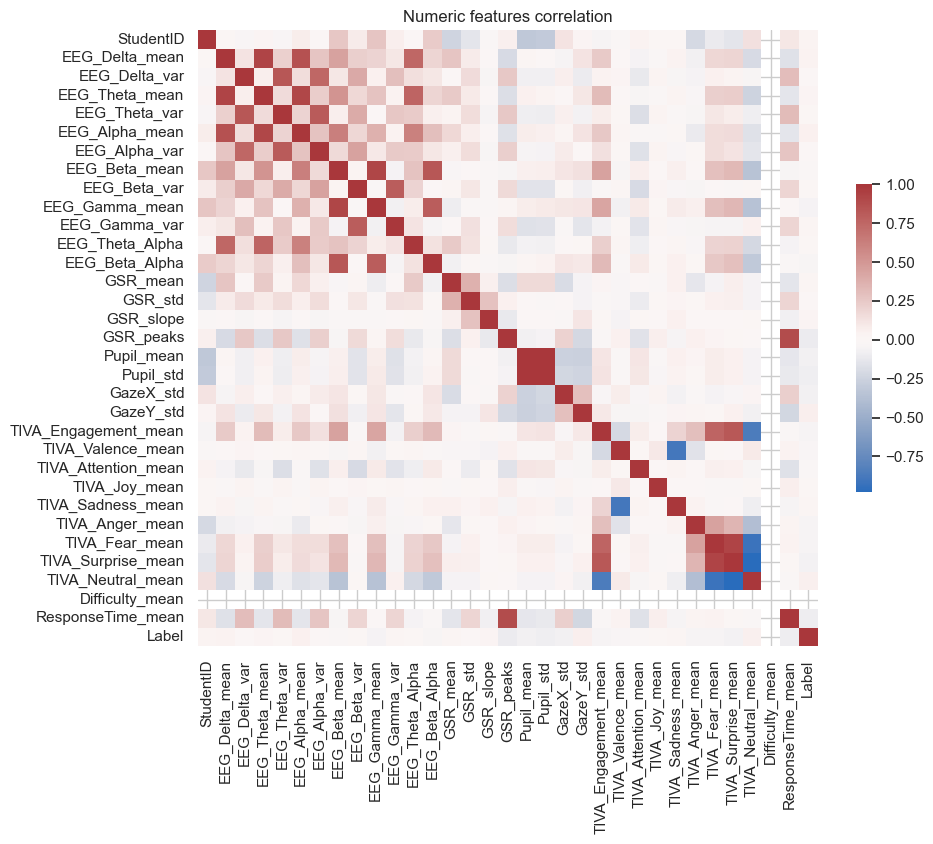

In [19]:
#EDA: missing values, class balance, correlations
# Missing values
missing = df.isna().mean().sort_values(ascending=False)
display(missing[missing > 0].to_frame("fraction_missing").head(30))

# Target balance
if TARGET_COL in df.columns:
    print("Target value counts:")
    display(df[TARGET_COL].value_counts(dropna=False).to_frame("count"))

# Correlations (numeric only)
num_df = df.select_dtypes(include=[np.number])
if num_df.shape[1] > 1:
    corr = num_df.corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, cmap="vlag", center=0, cbar_kws={'shrink':0.5})
    plt.title("Numeric features correlation")
    plt.show()
else:
    print("Not enough numeric columns to compute correlation heatmap.")


In [21]:
from sklearn.preprocessing import OneHotEncoder

# Identify numeric & categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET_COL in numeric_cols:
    numeric_cols.remove(TARGET_COL)

categorical_cols = df.select_dtypes(include=['object','category','bool']).columns.tolist()
if TARGET_COL in categorical_cols:
    categorical_cols.remove(TARGET_COL)

print(f"Numeric columns: {len(numeric_cols)}; Categorical columns: {len(categorical_cols)}")

# Pipelines
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())  # robust to outliers
])

#  updated parameter name for new sklearn versions
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("cat", categorical_pipeline, categorical_cols)
], remainder="drop", verbose_feature_names_out=False)


Numeric columns: 32; Categorical columns: 1


In [22]:
# Fit-transform on full dataset OR only on features (no leaking target)
X = df.drop(columns=[TARGET_COL]) if TARGET_COL in df.columns else df.copy()
y = df[TARGET_COL] if TARGET_COL in df.columns else None

print("Fitting preprocessor on X shape:", X.shape)
X_processed = preprocessor.fit_transform(X)

# Get feature names after transformation
def get_feature_names(preprocessor):
    # Works with sklearn >=1.0 ColumnTransformer naming
    out_names = []
    if hasattr(preprocessor, "transformers_"):
        for name, trans, cols in preprocessor.transformers_:
            if name == "remainder":
                continue
            if hasattr(trans, "named_steps") and "onehot" in trans.named_steps:
                ohe = trans.named_steps["onehot"]
                in_cols = cols
                ohe_cols = ohe.get_feature_names_out(in_cols)
                out_names.extend(ohe_cols.tolist())
            else:
                out_names.extend(cols)
    return out_names

feature_names = get_feature_names(preprocessor)
print("Processed features:", len(feature_names))

# Convert to DataFrame
X_proc_df = pd.DataFrame(X_processed, columns=feature_names, index=X.index)
display(X_proc_df.head(3))






Fitting preprocessor on X shape: (1448, 33)
Processed features: 54


,StudentID,EEG_Delta_mean,EEG_Delta_var,EEG_Theta_mean,EEG_Theta_var,EEG_Alpha_mean,EEG_Alpha_var,EEG_Beta_mean,EEG_Beta_var,EEG_Gamma_mean,...,TrialID_Item20,TrialID_Item3,TrialID_Item4,TrialID_Item5,TrialID_Item6,TrialID_Item7,TrialID_Item8,TrialID_Item9,TrialID_spl1,TrialID_spl2
0,-0.947368,-1.370069,-0.487402,-1.005474,-0.619364,-0.775826,-0.232434,-0.248998,-0.418008,-0.620357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.947368,-0.050456,0.607803,-0.220604,0.999145,-0.053297,1.293091,-0.075660,0.003049,-0.219706,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.947368,0.268942,0.935666,0.096330,1.478190,0.246744,0.568738,0.032229,-0.082874,-0.350830,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# Merge with target if present
if y is not None:
    out_df = pd.concat([X_proc_df, y.reset_index(drop=True)], axis=1)
else:
    out_df = X_proc_df.copy()

# Write CSV
PROCESSED_CSV_PATH.parent.mkdir(parents=True, exist_ok=True)
out_df.to_csv(PROCESSED_CSV_PATH, index=False)
print(f"Saved processed features to: {PROCESSED_CSV_PATH} (shape: {out_df.shape})")

# Persist preprocessor & scaler (joblib)
save_joblib(preprocessor, PREPROCESSOR_PATH)


Saved processed features to: C:\Users\alfiy\ByteBuzz\Notebooks\data\processed_features.csv (shape: (1448, 55))
Saved: C:\Users\alfiy\ByteBuzz\Notebooks\models\preprocessor.joblib


In [24]:
# Create a train/test split so downstream notebooks start from same split
if y is not None:
    X_train, X_test, y_train, y_test = train_test_split(
        X_proc_df, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y if y.nunique() > 1 else None
    )

    X_train.to_csv(DATA_DIR / "X_train.csv", index=False)
    X_test.to_csv(DATA_DIR / "X_test.csv", index=False)
    y_train.to_csv(DATA_DIR / "y_train.csv", index=False)
    y_test.to_csv(DATA_DIR / "y_test.csv", index=False)

    print("Saved train/test split to data/ (X_train.csv, X_test.csv, y_train.csv, y_test.csv)")
else:
    # If no target, save full processed features only
    X_proc_df.to_csv(DATA_DIR / "processed_features_no_target.csv", index=False)
    print("No target found; saved processed features to processed_features_no_target.csv")


Saved train/test split to data/ (X_train.csv, X_test.csv, y_train.csv, y_test.csv)


In [25]:
# Quick baseline to validate preprocess: simple classifier (only if y present)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

if y is not None:
    clf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, preds))
    print(classification_report(y_test, preds))
    # Save model for reference
    joblib.dump(clf, MODELS_DIR / "baseline_random_forest.joblib")
    print("Saved baseline model to models/baseline_random_forest.joblib")
else:
    print("Skipping baseline model because no target was detected.")


Accuracy: 0.7724137931034483
              precision    recall  f1-score   support

           0       0.50      0.08      0.13        66
           1       0.78      0.98      0.87       224

    accuracy                           0.77       290
   macro avg       0.64      0.53      0.50       290
weighted avg       0.72      0.77      0.70       290

Saved baseline model to models/baseline_random_forest.joblib
